In [1]:
import numpy as np
import cv2
from hdrtool import hdr
from hdrtool import align
import pandas as pd
import os
import importlib
import time
import matplotlib.pyplot as plt

In [2]:
IMGDIR = './example'
META = './example/sample.csv'
OUTPUT_PATH = 'output.jpg'
HDR_PATH = 'output.hdr'

## Load Meta Data

In [3]:
df = pd.read_csv(META, sep='\s+')

In [4]:
df['exposetime'] = 1/df['1/shutter_speed']

In [5]:
# read the images
imgs = [cv2.imread(os.path.join(IMGDIR,fn)) for fn in df.Filename]

## Image alignment

In [6]:
image_alignment = align.ImageAlignment()

def solve_alignment(images, d=4):
    for i in range(1, len(images)):
        print('\r[Alignment] %d' % (i + 1), end='')
        images[i] = image_alignment.fit(images[i], images[i-1], d)
    print()
    return images

imgs = solve_alignment(imgs)

[Alignment] 6


## Plotting images

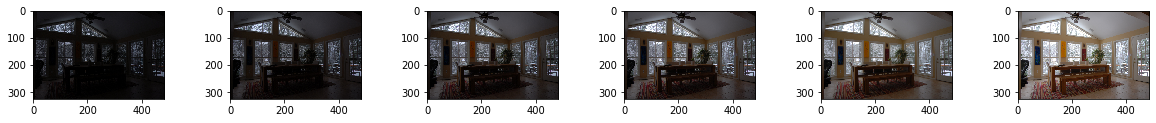

In [47]:
fig=plt.figure(figsize=(20, 10))
columns = len(imgs)
rows = 1
for i in range(1, columns*rows+1):
    img = imgs[i-1]
    fig.subplots_adjust(wspace=0.5)
    fig.add_subplot(rows, columns, i)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) #Opencv use BGR instead of RGB
    #plt.plot([190],[130], 'bo')
plt.show()

## Compute HDR

In [45]:
#relode module
importlib.reload(hdr)
importlib.reload(align)

<module 'hdrtool.align' from '/home/tsai/workspace/high-dynamic-range-image/hdrtool/align.py'>

In [48]:
hdrimg = hdr.computeHDR(imgs, np.log(df.exposetime))

channel: 0
    sampling intensities...
    running time: 0.4570045471191406
    computing response curve...
    running time: 0.5540158748626709
    building irradiance map using np...


/home/tsai/workspace/high-dynamic-range-image/hdrtool/hdr.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  one_hot[flat_grids + [arr.ravel()]] = 1


    running time: 3.9910058975219727
channel: 1
    sampling intensities...
    running time: 0.457042932510376
    computing response curve...
    running time: 0.5409750938415527
    building irradiance map using np...
    running time: 3.993645668029785
channel: 2
    sampling intensities...
    running time: 0.45658230781555176
    computing response curve...
    running time: 0.5454103946685791
    building irradiance map using np...
    running time: 3.990511417388916


In [51]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker

def plot_radiance(radiance, colors= ['Blue', 'Green', 'Red']):
    print('[Plot] radiance')
    def fmt(x, pos): return '%.3f' % np.exp(x)

    height, width, channels = radiance.shape
    ln_radiance = np.log(radiance)

    plt.clf()
    fig, ax = plt.subplots(1, channels, figsize=(5 * channels, 5))

    for c in range(channels):
        im = ax[c].imshow(ln_radiance[:, :, c], cmap='jet')
        ax[c].set_title(colors[c])
        ax[c].set_axis_off()
        divider = make_axes_locatable(ax[c])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, format=ticker.FuncFormatter(fmt))

### plotting HDR image

[Plot] radiance


<Figure size 432x288 with 0 Axes>

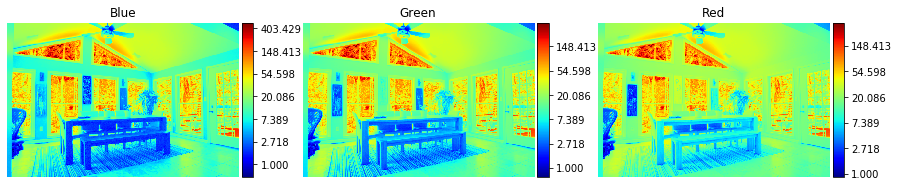

In [57]:
plot_radiance(hdrimg, ['Blue', 'Green', 'Red'])

In [54]:
# save high dynamic range image
cv2.imwrite(HDR_PATH, hdrimg)

True

### Global Tone Mapping

In [55]:
 # map hdr image to 0-255
hdr_mapped = hdr.globalToneMapping(hdrimg, Lwhite=np.exp(hdrimg.max())*0.8, alpha=0.5)

cv2.imwrite(OUTPUT_PATH, (hdr_mapped).astype(np.uint8) )

/home/tsai/workspace/high-dynamic-range-image/hdrtool/hdr.py:212: RuntimeWarning: overflow encountered in double_scalars
  image_corrected = Ldf


True

### Plotting Mapped Image

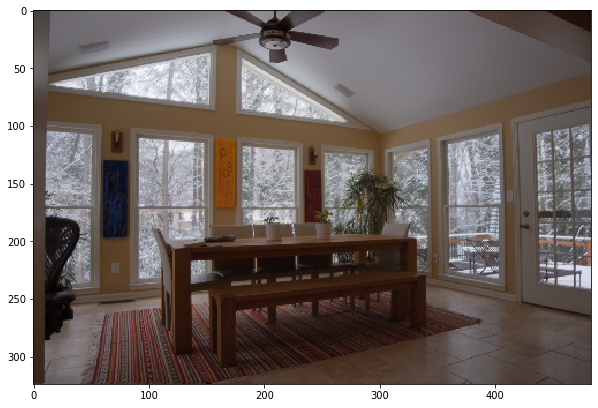

In [56]:
plt.figure(figsize=(10, 17))
plt.imshow(cv2.cvtColor((hdr_mapped).astype(np.uint8), cv2.COLOR_BGR2RGB))